In [128]:
import time

import  torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data as td

定义变量

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_works = 4
batch_size = 64
input_dim= 100
epochs = 25
print("run on ",device.type)

run on  cuda


In [130]:
from typing import Iterable


# loading data
def loading_minist_data(batch_siz:int, works:int)->(Iterable,Iterable):

    train_set = torchvision.datasets.MNIST(root="./data",train=True,transform=torchvision.transforms.ToTensor(),download=True)
    test_set = torchvision.datasets.MNIST(root="./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)
    return td.DataLoader(dataset=train_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True), td.DataLoader(dataset=test_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True)

train_iter ,test_iter = loading_minist_data(batch_size,4)


In [131]:
print("train_iter len ",len(train_iter))
print("all size ",len(train_iter)*batch_size)

train_iter len  937
all size  59968


In [132]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,256),
            nn.LeakyReLU(0.01),
            nn.Linear(256,128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,1),
            nn.Sigmoid(),
        ).to(device)
        self.cnt=0
        self.running_loss=0
        self.loss_func = nn.BCELoss()
        self.loss_metric=[]
        self.optimizer = torch.optim.Adam(self.parameters(),lr=0.001)
        pass
    def forward(self,inputs):
        return self.model(inputs)
    def train(self,inputs,targets):
        out = self.forward(inputs)
        loss = self.loss_func(out,targets)
        self.running_loss += loss.detach().item()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    def evaluate_loss(self):
        ts = self.running_loss/(len(train_iter)*batch_size)
        self.loss_metric.append(ts)

        self.running_loss=0

        pass
class Generator(nn.Module):
    def __init__(self,in_dim:int):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 200),
            nn.LeakyReLU(0.02),
            # nn.LayerNorm(200),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            # nn.ReLU(True),
            # nn.Linear(256,28*28),
            # nn.Tanh()
            nn.Sigmoid()
        ).to(device)

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        # counter and accumulator for progress
        self.loss_metric = []
        self.running_loss =0
    def forward(self,inputs):
        return self.model(inputs).view(batch_size,28,28)
    def train(self,D:Discriminator,inputs,targets):
        gen_out = self.forward(inputs)
        # print(gen_out.shape)
        d_out = D.forward(gen_out)
        loss  = D.loss_func(d_out,targets)
        self.running_loss += loss.detach().item()
        # print(self.running_loss)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    def evaluate_loss(self):
        print("G running loss ",self.running_loss)
        ts = self.running_loss/(len(train_iter)*batch_size)
        self.loss_metric.append(ts)
        self.running_loss=0
        pass
def generate_random_seed(size):
    random_data = torch.randn(size*batch_size).view(batch_size,size)
    return random_data.to(device)


In [133]:
D = Discriminator()
for k in  range(3):
    for it,_ in train_iter:
        it = it.to(device)
        y = torch.ones(size=(64,1),dtype=torch.float32)
        y = y.to(device)
        D.train(it,y)
    # print(len(train_iter)*batch_size)
    print(D.running_loss/(len(train_iter)*batch_size))
    D.running_loss =0


4.500629624042516e-05
1.8649228976791295e-08
3.940977928252997e-09


generate nums is run on  cuda:0


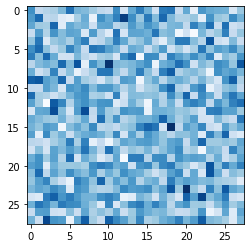

In [134]:
G = Generator(input_dim)

print("generate nums is run on ",generate_random_seed(input_dim).device)

output = G.forward(generate_random_seed(input_dim))
# img = output.detach().numpy().reshape(28,28)
plt.imshow(output.cpu().detach().numpy()[0], interpolation='none', cmap='Blues')

In [135]:
%%time
D = Discriminator()
G = Generator(input_dim)
for i in range(epochs):
    print("epoch  {} of {}  ".format(i+1,epochs))
    time_start = time.time()
    for tr_item,_ in train_iter:
        tr_item = tr_item.to(device)
        true_label = torch.ones(size=(batch_size,1),dtype=torch.float32).to(device)
        fake_label = torch.zeros(size=(batch_size,1),dtype=torch.float32).to(device)
        D.train(tr_item,true_label)

        D.train(G.forward(generate_random_seed(input_dim)).detach() , fake_label)
        #
        G.train(D,generate_random_seed(input_dim),true_label)
    D.evaluate_loss()
    G.evaluate_loss()
    print("spend time {}   D loss {} ,G loss {} ".format(time.time()-time_start,D.loss_metric[i],G.loss_metric[i]))

        # break

epoch  1 of 25  
G running loss  9988.307329595089
spend time 10.56075668334961   D loss 0.0003498051002574288 ,G loss 0.16656062115786902 
epoch  2 of 25  
G running loss  8359.850031375885
spend time 10.168806791305542   D loss 0.0002794478987509588 ,G loss 0.13940518328735133 
epoch  3 of 25  
G running loss  8611.433709144592
spend time 10.249592304229736   D loss 0.00025865091625144464 ,G loss 0.14360048207618384 
epoch  4 of 25  
G running loss  8927.152048587799
spend time 10.575720310211182   D loss 0.00033349862127621585 ,G loss 0.14886526228301425 
epoch  5 of 25  
G running loss  8697.849755764008
spend time 10.552781343460083   D loss 0.0004319129274532527 ,G loss 0.14504151807237206 
epoch  6 of 25  
G running loss  8098.990706443787
spend time 10.655506372451782   D loss 0.0005504955832555731 ,G loss 0.13505520788493508 
epoch  7 of 25  
G running loss  7609.170108318329
spend time 10.700387001037598   D loss 0.0007139211635652264 ,G loss 0.12688717496528698 
epoch  8 of 

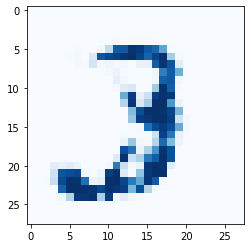

In [136]:
output = G.forward(generate_random_seed(input_dim))
img = output.detach().cpu().numpy().reshape(64,28,28)
plt.imshow(img[9], interpolation='none', cmap='Blues')

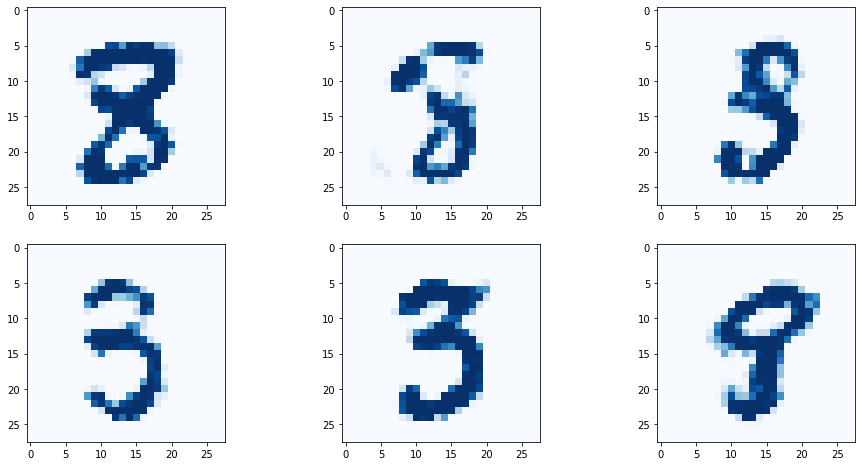

In [137]:
f,axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(input_dim))
        img = output.detach().cpu().numpy()[i*3+j].reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

# for it,_ in train_iter:
    # plt.imshow(it[0].reshape(28,28),cmap="Blues")
    # break